In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pyemma
import mdtraj as md
import dask.array as da
import multiprocessing
import functools
from matplotlib import colors
import mdtraj as md

In [2]:
from numpy_indexed import group_by as group_by_


def group_by(values, index=None):

    if index is None:
        index = np.arange(len(values))

    return group_by_(values).split_array_as_list(index)

In [3]:
def dask_svd(x,
             compressed: bool = False,
             k: int = 2,
             n_power_iter=4,
             n_oversamples = 15,
             compute = True,
             n_chunks: int = None,
             svals=False,
             transposed=False):
    getter = lambda x: x.compute()

    row, col = x.shape

    # this is only going to help if the svd is compressed

    if col > row:
        transposed = True
        x = x.T

    # chunking has to be in one dimension
    n_chunks = int((x.shape[0] + 1) / multiprocessing.cpu_count()) if n_chunks is None else n_chunks
    chunks = (n_chunks, x.shape[1])

    x = da.from_array(x, chunks=chunks)

    if svals:
        x = da.linalg.svd_compressed(x, k=k, n_power_iter=n_power_iter,
                                     n_oversamples=n_oversamples,
                                     compute=compute)[1].compute()
        return x

    if compressed:
        x = list(map(getter, da.linalg.svd_compressed(x, k=k, n_power_iter=n_power_iter,
                                                      n_oversamples=n_oversamples,
                                                      compute=compute)))

    else:
        x = list(map(getter, da.linalg.svd(x)))

    if transposed:
        # to apply the transpose of the product of 3 matrices, need to flip the ordering
        return [i.T for i in x][::-1]
    else:
        return x
    
def center(x: np.ndarray, weights: np.ndarray = None):
    return x - x.mean(0) if weights is None else x - (weights[:,None] * x).sum(0)


In [4]:
def dask_pca(x: np.ndarray, dim: int = None, weights: np.ndarray = None):
    x_mean_free = center(x, weights=weights)
    x_weighted = x_mean_free / np.sqrt(len(x) - 1) if weights is None else x_mean_free * np.sqrt(weights[:,None]) 
    u,s,vt = dask_svd(x_weighted, compressed=True, k=dim, svals=False)
    proj = x_mean_free @ vt.T
    return proj, s, vt.T


In [5]:
def cov(x: np.ndarray, y: np.ndarray = None,
        weights: np.ndarray = None,
        norm: bool = True,
        center_: bool = True,
        bessel_correction: bool = True):

    n = len(x)

    if norm:
        if weights is not None:
            weights = weights.squeeze()
            #in case weights are a matrix in which case the norm isn't always obvious
            norm = weights.sum() if weights.ndim == 1 else 1
        else:
            norm = (n - 1) if bessel_correction else n
    else:
        norm = 1

    if y is None:
        y = np.copy(x)

    if center_:
        x, y = (center(i, weights=weights) for i in (x, y))

    y = y.reshape(n, -1)

    if weights is not None:
        # weight for every frame
        if weights.ndim == 1:
            y = (weights[:, None] * y).reshape(n, -1)  # same as np.diag(weights) @ y
        # weight matrix
        else:
            assert (weights.shape[0] == weights.shape[1]) and (weights.shape[1] == y.shape[0]), \
                ("weights should be a 1D matrix with len == y.shape[0]"
                 " or a square matrix with shape == (y.shape[0], y.shape[0])")

            y = (weights @ y).reshape(n, -1)

    return (x.T @ y) / norm

def pca(x: np.ndarray,
        dim: int = None,
        weights: np.ndarray = None):
    """compute the business half of econ svd"""
    l, v = np.linalg.eigh(cov(x, weights=weights))
    idx = l.argsort()[::-1]
    v = v[..., idx]
    l = l[idx]
    l, v = l[:dim], v[..., :dim]
    projection = center(x) @ v
    return projection, l, v

In [6]:
def Kmeans(p, n_clusters, n_dim):
    # ensure data is correct shape, num dims
    p = np.copy(p[..., :n_dim])
    # use kmeans class from sklearn
    kmeans = KMeans(n_clusters=n_clusters)
    # fit the clustering
    dtraj = kmeans.fit_predict(p)
    # find frames for each cluster
    frames_cl = sort_indices_list(indices_list=group_by(dtraj),
                                  obs=kmeans.transform(p).min(1),
                                  max=False)
    # return dtraj and frames for each cluster sorted by distance from centroids
    return dtraj, frames_cl

def sort_indices_list(indices_list: list,
                      obs: "numpy array with values corresponding to indices",
                      max: bool=True):
    """Sort each array in a list of indices arrays based on their values in obs.
       Returns the resorted indices_array, the value of the stat for each set of indices
       and the sorted indices of the list"""
    sort = functools.partial(sort_by_val_in, value=obs, max=max)
    return list(map(sort, indices_list))

def sort_by_val_in(indices: np.ndarray,
                   value: np.ndarray,
                   max: bool = False):
    stride = -1 if max else 1
    return indices[np.argsort(value[indices])[::stride]]

In [7]:
distances = np.load('/Users/kaushikb/Desktop/OXA24/distances.npy')

In [8]:
pca_unbiased = np.loadtxt('/Users/kaushikb/Desktop/OXA24/proj_ub.txt')

In [9]:
proj_ub, s_ub, vt_ub =dask_pca(distances, dim=2, weights=None)

In [10]:
weights = np.loadtxt('/Users/kaushikb/Desktop/OXA24/output_all_shifts/weights/combined_data/CA-CB-H-C-N/weights_final.dat')

In [11]:
proj_rw, s_rw, vt_rw = dask_pca(distances, dim=2, weights=weights)

In [12]:
idx = np.abs(vt_ub[:,0]).argsort()[::-1]
idx_ = np.abs(vt_ub[:,1]).argsort()[::-1]

In [13]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

In [16]:
trj

<mdtraj.Trajectory with 34629 frames, 3899 atoms, 244 residues, and unitcells at 0x7fca997bf760>

In [17]:
distances.shape

(34629, 29646)

In [21]:
indices.shape

(29646, 2)

In [20]:
indices = np.stack(np.triu_indices(244,1), axis=1)

In [22]:
get_extrema = lambda x: (x.argmin(), x.argmax())

In [23]:
extrema_distances_ub = list(map(get_extrema, vt_ub.T))

In [24]:
extrema_distances_ub

[(15503, 16040), (16309, 269)]

In [30]:
residues = np.asarray(list(trj.top.residues))
residues_pairs = residues[indices]

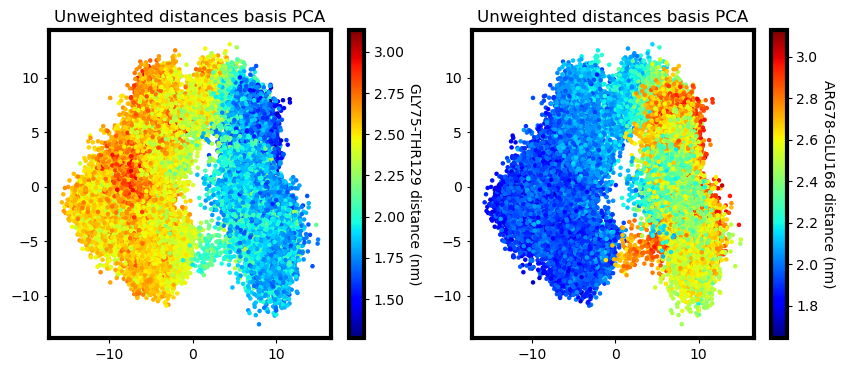

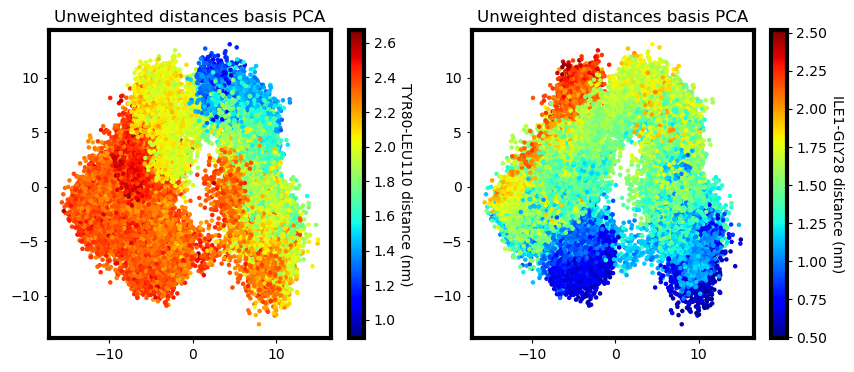

In [53]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for i,ax in zip(extrema_distances_ub[0], axes.flat):
    ax.set_title("Unweighted distances basis PCA") 
    s = ax.scatter(*proj_ub[:,:2].T, c = distances[:,i], s = 5, cmap='jet')
    cbar = plt.colorbar(s, ax=ax)
    cbar.set_label(f"{residues_pairs[i][0]}-{residues_pairs[i][1]} distance (nm)", rotation=270, labelpad=12)



fig, axes = plt.subplots(1,2, figsize=(10,4))
for i,ax in zip(extrema_distances_ub[1], axes.flat):
    ax.set_title("Unweighted distances basis PCA") 
    s = ax.scatter(*proj_ub[:,:2].T, c = distances[:,i], s = 5, cmap='jet')
    cbar = plt.colorbar(s, ax=ax)
    cbar.set_label(f"{residues_pairs[i][0]}-{residues_pairs[i][1]} distance (nm)", rotation=270, labelpad=12)


In [54]:
most_important_dist_indices = abs(vt_ub).argsort(0)[::-1]

In [55]:
reduced_feature_indices = np.unique(most_important_dist_indices[:1000].flatten())

In [56]:
proj, l_red, v_red = pca(distances[:, reduced_feature_indices])

Text(0, 0.5, 'Principal Component 2')

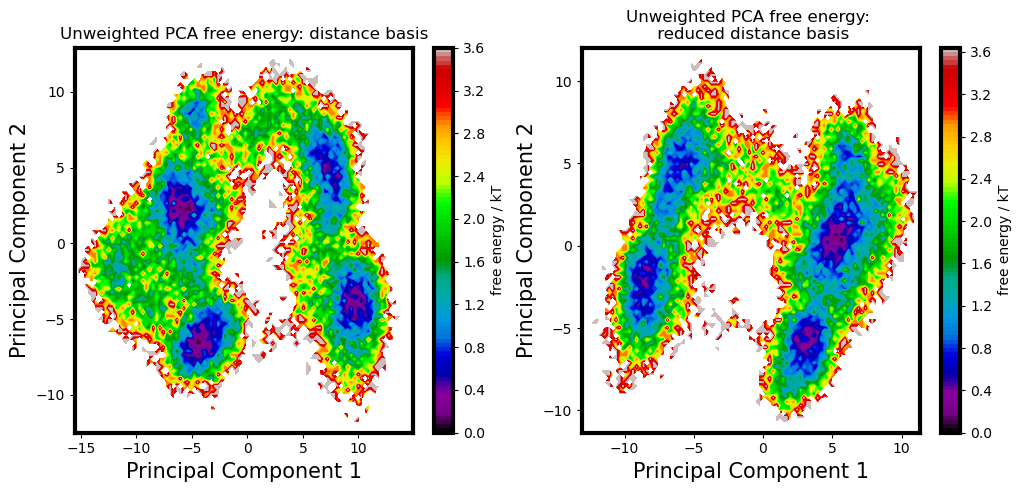

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
pyemma.plots.plot_free_energy(*proj_ub[:,:2].T, ax=axs[0])
pyemma.plots.plot_free_energy(*proj[:,:2].T, ax=axs[1])

axs[0].set_title("Unweighted PCA free energy: distance basis")
axs[1].set_title("Unweighted PCA free energy: \n reduced distance basis")
axs[0].set_xlabel("Principal Component 1", size=15)
axs[0].set_ylabel("Principal Component 2", size=15)
axs[1].set_xlabel("Principal Component 1", size=15)
axs[1].set_ylabel("Principal Component 2", size=15)

In [58]:
proj_r, l_red_r, v_red_r = pca(distances[:, reduced_feature_indices], weights=weights)

Text(0, 0.5, 'Principal Component 2')

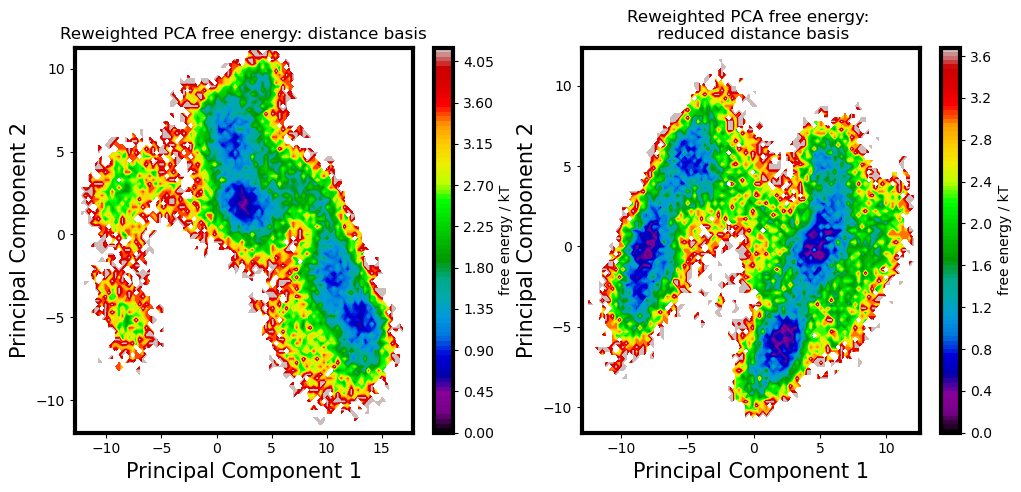

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
pyemma.plots.plot_free_energy(*proj_rw[:,:2].T, ax=axs[0])
pyemma.plots.plot_free_energy(*-proj_r[:,:2].T, ax=axs[1])

axs[0].set_title("Reweighted PCA free energy: distance basis")
axs[1].set_title("Reweighted PCA free energy: \n reduced distance basis")
axs[0].set_xlabel("Principal Component 1", size=15)
axs[0].set_ylabel("Principal Component 2", size=15)
axs[1].set_xlabel("Principal Component 1", size=15)
axs[1].set_ylabel("Principal Component 2", size=15)

Text(0, 0.5, 'Principal Component 2')

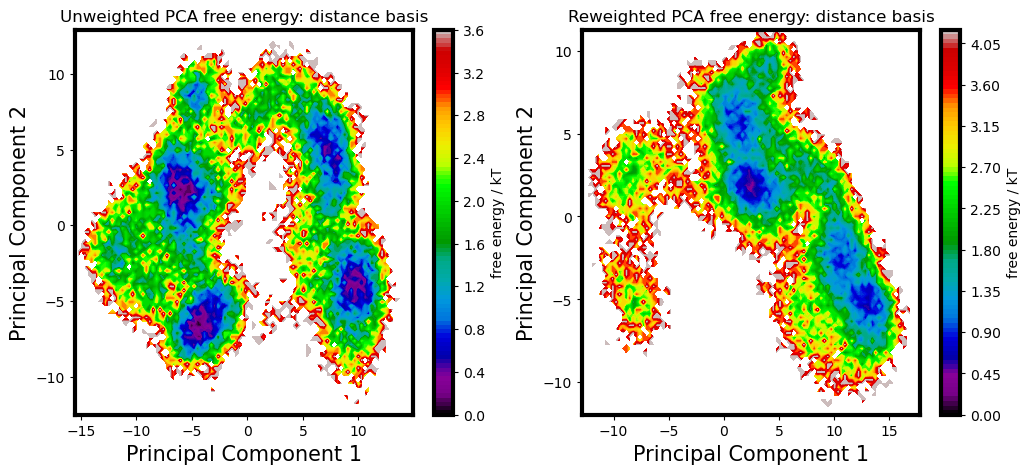

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
pyemma.plots.plot_free_energy(*proj_ub[:,:2].T, ax=axs[0])
pyemma.plots.plot_free_energy(*proj_rw[:,:2].T, ax=axs[1])

axs[0].set_title("Unweighted PCA free energy: distance basis")
axs[1].set_title("Reweighted PCA free energy: distance basis")
axs[0].set_xlabel("Principal Component 1", size=15)
axs[0].set_ylabel("Principal Component 2", size=15)
axs[1].set_xlabel("Principal Component 1", size=15)
axs[1].set_ylabel("Principal Component 2", size=15)

Text(0, 0.5, 'Principal Component 2')

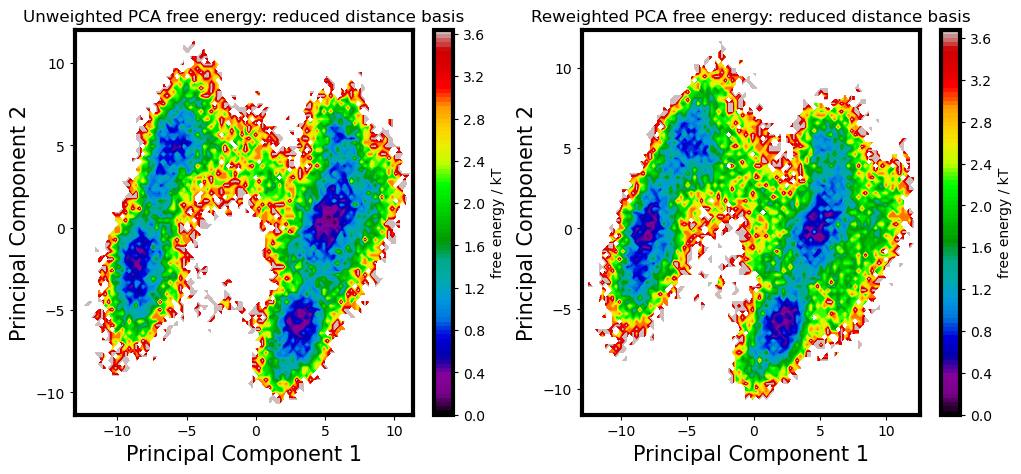

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
pyemma.plots.plot_free_energy(*proj[:,:2].T, ax=axs[0])
pyemma.plots.plot_free_energy(*-proj_r[:,:2].T, ax=axs[1])

axs[0].set_title("Unweighted PCA free energy: reduced distance basis")
axs[1].set_title("Reweighted PCA free energy: reduced distance basis")
axs[0].set_xlabel("Principal Component 1", size=15)
axs[0].set_ylabel("Principal Component 2", size=15)
axs[1].set_xlabel("Principal Component 1", size=15)
axs[1].set_ylabel("Principal Component 2", size=15)
    
   

In [63]:
tic = pyemma.coordinates.tica(distances[:, reduced_feature_indices], lag=10, dim=2).get_output()[0]

/Users/kaushikb/opt/anaconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/kaushikb/opt/anaconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Text(0.5, 1.0, 'TICA using distances as basis')

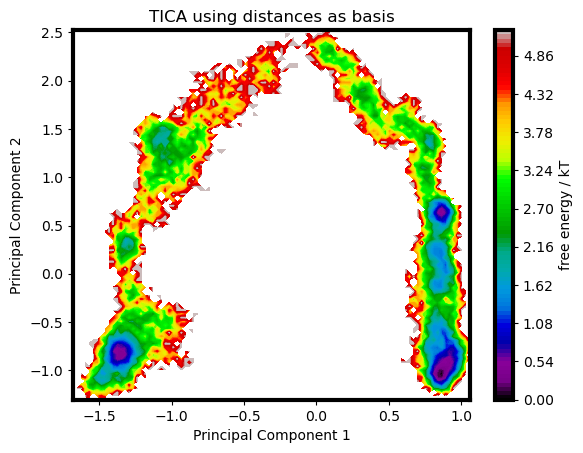

In [64]:
pyemma.plots.plot_free_energy(*tic[:,:2].T)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("TICA using distances as basis")

In [65]:
dtraj_ub, frames_cl_ub = Kmeans(proj_ub, 10, 2)

In [66]:
def cluster_plot(data, cl_assignment, cmap, title=str):
    plt.figure(figsize=(10,6))
    plt.scatter(data[:,0], data[:,1], c= cl_assignment, cmap=cmap)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.colorbar(label="Cluster")

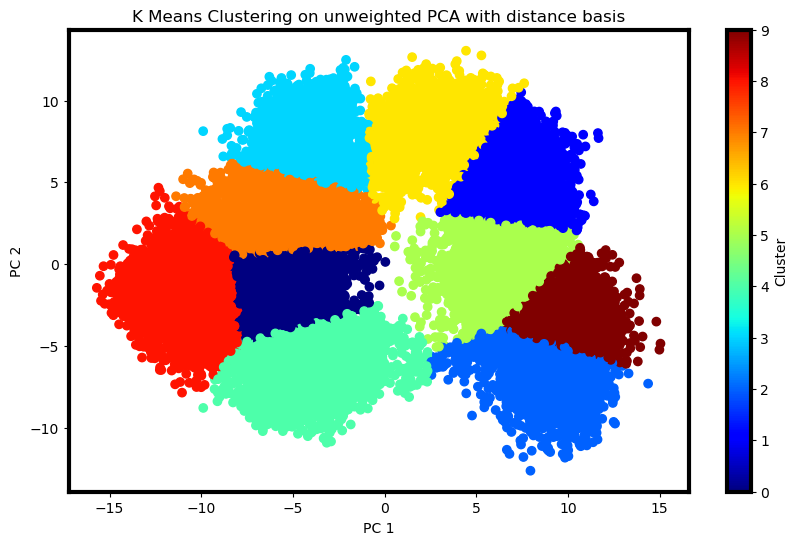

In [68]:
cluster_plot(proj_ub, dtraj_ub, 'jet', "K Means Clustering on unweighted PCA with distance basis")

In [69]:
dtraj_red, frames_cl_red = Kmeans(proj, 10, 2)

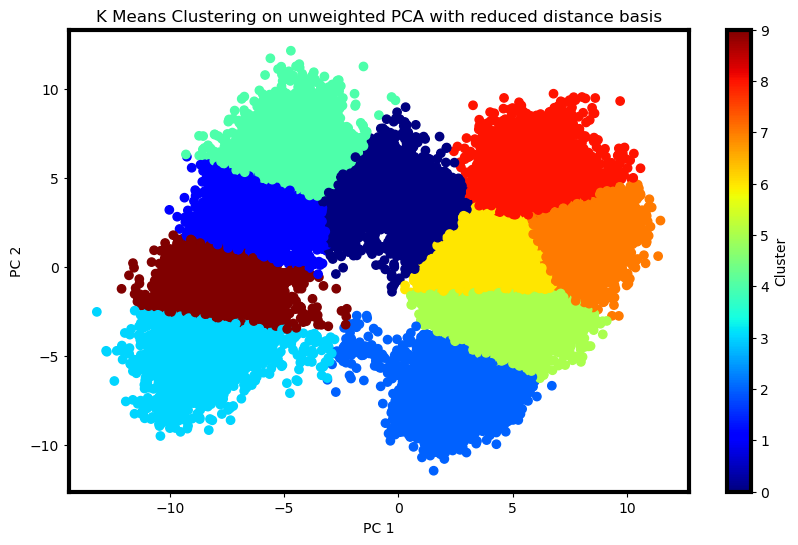

In [71]:
cluster_plot(proj, dtraj_red, 'jet', "K Means Clustering on unweighted PCA with reduced distance basis")

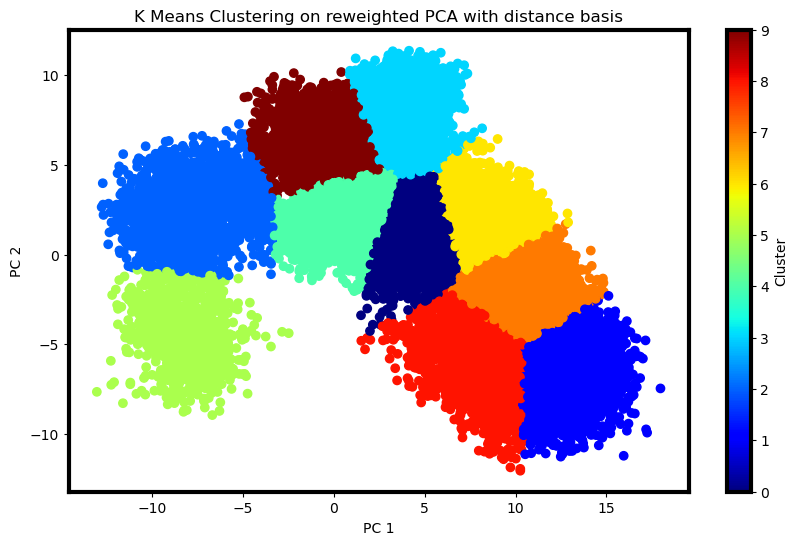

In [77]:
dtraj_rw, frames_cl_rw = Kmeans(proj_rw, 10, 2)

cluster_plot(proj_rw, dtraj_rw, 'jet', "K Means Clustering on reweighted PCA with distance basis")

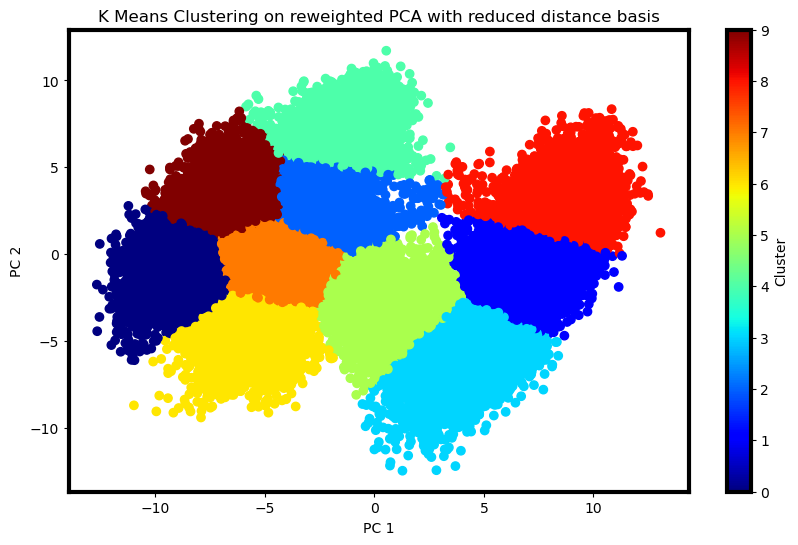

In [80]:
dtraj_r_red, frames_cl_r_red = Kmeans(proj_r, 10, 2)

cluster_plot(proj_r, dtraj_r_red, 'jet', "K Means Clustering on reweighted PCA with reduced distance basis")

In [72]:
parm_file = '/Users/kaushikb/Desktop/OXA24/oxa24wt-nowater.parm7'
trajectory = '/Users/kaushikb/Desktop/OXA24/oxa24wt-nowater-Prodlong.nc'

In [73]:
pdb = md.load_prmtop(parm_file)

trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]

top = trj.topology
top = top.subset(top.select("protein"))
trj = trj.atom_slice(trj.top.select('resid <= 243'))
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [81]:
coord = trj.xyz

In [158]:
!pip install shapeGMMTorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 MB 19.7 MB/s eta 0:00:0000:0100:01
  Created wheel for shapeGMMTorch: filename=shapeGMMTorch-1.5.1-py3-none-any.whl size=18246 sha256=5f158e0c0c59d0be6aac91dbf87af558531dccc634a3035dcf558727c66d7afd
  Stored in directory: /Users/kaushikb/Library/Caches/pip/wheels/e7/ea/85/06b97a4bc3dc9ff6b022b281a4a4739ea99d0ac99249f93353
Successfully built shapeGMMTorch


In [82]:
import numpy as np
import torch
from shapeGMMTorch import torch_align
import warnings
warnings.filterwarnings('ignore')
import random

# class
class align_xyz:

    def __init__(self, rot_type="uniform", kabsch_thresh=1E-1, dtype=torch.float32, device=torch.device("cpu")):
        """
        Initialize size-and-shape GMM.
        rot_type                - string defining the type of rotational alignment to use.  Options are 'kronecker' and 'uniform'.  Defualt is 'uniform'.
        kabsch_thresh           - float dictating convergence criteria for each alignment step.  Default value is 1e-1.
        dtype                   - Data type to be used.  Default is torch.float32.
        device                  - device to be used.  Default is torch.device('cuda:0') device.
        """

        self.rot_type = rot_type                                # string
        self.kabsch_thresh = kabsch_thresh                      # float
        self.dtype = dtype                                      # torch dtype
        self.device = device                                    # torch device
        self._plda_fit_flag = False                             # boolean tracking if GMM has been fit.

    # fit the model
    def fit(self, traj_data: np.ndarray)-> np.ndarray:
        """
        traj_data (required)   - (n_frames, n_atoms, 3) float32 or float64 numpy array of particle positions.
        """

        # store some meta data
        self.n_training_frames = traj_data.shape[0]
        self.n_atoms = traj_data.shape[1]
        # pass trajectory data to device
        traj_tensor = torch.tensor(traj_data,dtype=self.dtype,device=self.device)
        # make sure trajectory is centered
        torch_align.torch_remove_center_of_geometry(traj_tensor,dtype=self.dtype,device=self.device)
        # perform global alignment
        if self.rot_type == 'uniform':
            aligned_traj_tensor, center_tensor, var_tensor = torch_align.torch_iterative_align_uniform(traj_tensor,thresh=self.kabsch_thresh,device=self.device,dtype=self.dtype)
            self.var = var_tensor.cpu().numpy()
            del var_tensor
        else:
            aligned_traj_tensor, center_tensor, precision_tensor, lpdet_tensor = torch_align.torch_iterative_align_kronecker(traj_tensor,thresh=self.kabsch_thresh,device=self.device,dtype=self.dtype)
            self.precision = precision_tensor.cpu().numpy()
            del precision_tensor
        self.center = center_tensor.cpu().numpy()
        return aligned_traj_tensor.cpu().numpy()
    
    



In [83]:
aligned_xyz = align_xyz().fit(coord)

In [84]:
proj_xyz, s_xyz, v_xyz = dask_pca(aligned_xyz.reshape(trj.n_frames, -1), dim=2)

In [85]:
proj_r_xyz, s_r_xyz, v_r_xyz = dask_pca(aligned_xyz.reshape(trj.n_frames, -1), dim=2, weights=weights)

Text(0, 0.5, 'Principal Component 2')

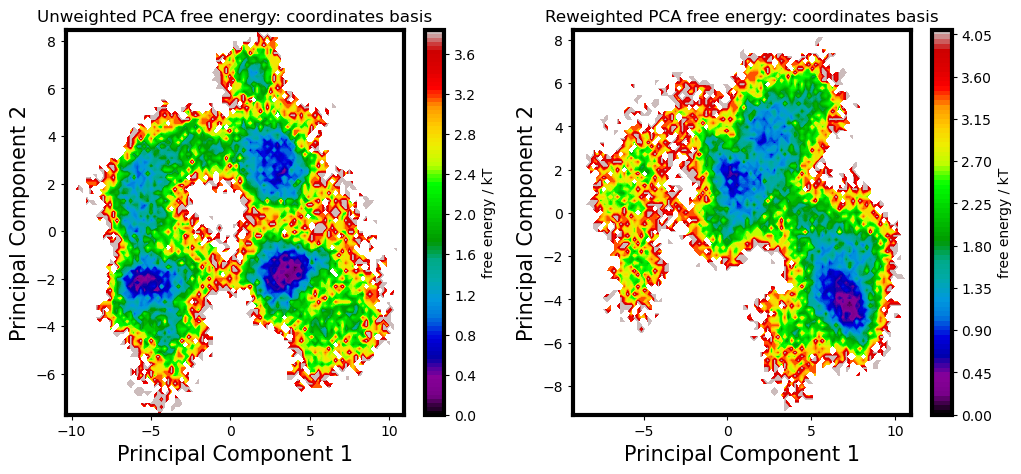

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
pyemma.plots.plot_free_energy(*proj_xyz.T, ax=axs[0])
pyemma.plots.plot_free_energy(*proj_r_xyz.T, ax=axs[1])

axs[0].set_title("Unweighted PCA free energy: coordinates basis")
axs[1].set_title("Reweighted PCA free energy: coordinates basis")
axs[0].set_xlabel("Principal Component 1", size=15)
axs[0].set_ylabel("Principal Component 2", size=15)
axs[1].set_xlabel("Principal Component 1", size=15)
axs[1].set_ylabel("Principal Component 2", size=15)

In [87]:
def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [88]:
rg=calc_Rg(trj)

In [89]:
def calc_sa(trj: "mdtraj Trajectory object",
            helix: "str to helix pdb file or mdtraj object"):

    helix = md.load(helix) if isinstance(helix, str) else helix

    trj, helix = (i.atom_slice(i.top.select("name CA")).center_coordinates() for i in (trj, helix))

    assert trj.n_atoms == helix.n_atoms, \
        "trj and helix trajectories do not contain the same number of CA atoms"

    selections = [f"resid {i} to {i + 5}" for i in range(0, trj.n_atoms - 5)]

    rmsd = np.asarray([md.rmsd(trj, helix, atom_indices=helix.topology.select(selection))
                       for selection in selections])

    sa = (1.0 - (rmsd / 0.08) ** 8) / (1 - (rmsd / 0.08) ** 12)

    return sa.T

In [90]:
sa = calc_sa(trj, '/Users/kaushikb/Desktop/OXA24/oxa24wt-nowater_helix.pdb' )

In [91]:
def get_color_list(n_colors: int, cmap: str, trunc=0, pre_trunc=0):
    cmap = getattr(plt.cm, cmap)
    cl = [cmap(i) for i in range(cmap.N)]
    return [cl[i] for i in np.linspace(1 + pre_trunc, len(cl) - 1 - trunc, n_colors).astype(int)]

In [94]:
from cycler import cycler

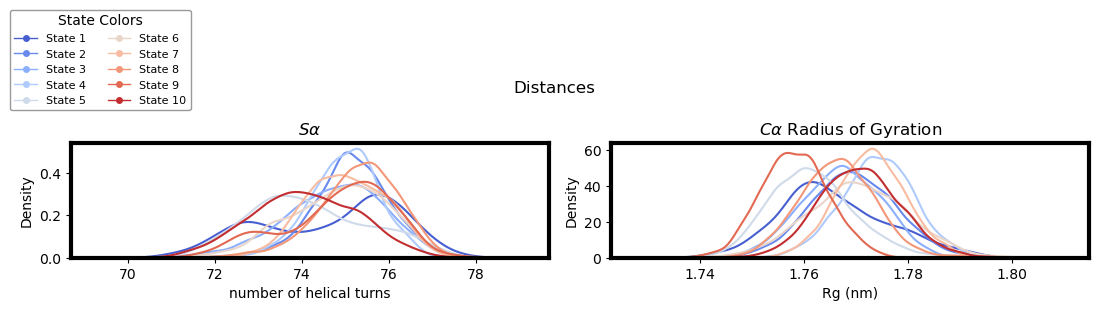

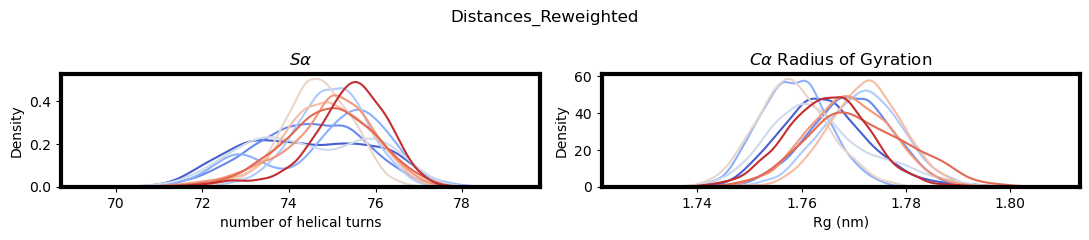

In [101]:
import seaborn as sns
from matplotlib.lines import Line2D

n_macro = 10
state_colors = color=get_color_list(n_macro,
                                              "coolwarm",
                                              trunc=10, 
                                              pre_trunc=10,
                                             )

titles = [r"$S\alpha$",
          r"$C\alpha$ Radius of Gyration"]

variables = [sa.sum(1), rg]
                
xlabels = ["number of helical turns", "Rg (nm)"]
count = 0

for indices_list, model in zip([frames_cl_ub, frames_cl_rw], "Distances,Distances_Reweighted".split(",")): 
    fig, axes = plt.subplots(1,2, figsize=(11,2.4))
    if count==0:
        count+=1
        
        legend_elements = [Line2D([0], [0],
                                  marker="o", 
                                  color=state_colors[i],
                                  label=f"State {i+1}",
                                  markerfacecolor=state_colors[i],
                                  markersize=4,
                                  lw=1)
                           for i in range(len(indices_list))]
        
        fig.legend(handles=legend_elements,title="State Colors",loc="upper left",
                   fontsize=8, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
                  bbox_to_anchor = [0,1.3])
        
        plt.subplots_adjust(top=.75)
        
    for title, xlabel, var, ax in zip(titles, xlabels, variables, axes.flat):
        ax.set_prop_cycle((cycler(color=get_color_list(n_macro,"coolwarm",
                                                                 trunc=10, 
                                                                 pre_trunc=10,
                                                                ))))
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        for i, indices in enumerate(indices_list):
            sns.kdeplot(var[indices], label=f"State {i+1}", ax=ax)
        
        fig.suptitle(model)
        fig.tight_layout()

In [105]:
frames_cl_ub

[array([ 3424,  9888,  3421, ...,  4749, 10656, 10653]),
 array([23051, 22280, 23429, ..., 23512, 23509, 21759]),
 array([31504, 32444, 32491, ..., 27056, 27039, 26727]),
 array([18751, 18504, 18131, ..., 18642, 18648, 14558]),
 array([ 5561,  6860,  5955, ..., 27077, 27015,  1053]),
 array([33950, 22718, 33584, ..., 27000, 26728, 17113]),
 array([20332, 20919, 19524, ..., 23648, 17128, 23649]),
 array([11432, 11997, 15180, ..., 11493, 11491, 17087]),
 array([1612, 1598, 3254, ..., 1221, 1222, 1220]),
 array([30050, 27420, 29436, ..., 30923, 32045, 32040])]

In [106]:
save_dcd = lambda idx, file, n=10, trj=trj : trj[idx[:n]].save_dcd(file)

In [109]:
for i, frames in enumerate(frames_cl_ub):
    save_dcd(frames, f"State_{i+1}.dcd")